In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

from sklearn.neighbors import kneighbors_graph

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import pycountry
from collections import Counter
import ast

from scipy.stats import pearsonr
from sklearn.cluster import DBSCAN
!pip install -q kneed
from kneed import KneeLocator

from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA


In [ ]:
df = pd.read_csv("train_clean.csv")

In [ ]:
numerical = ['awardWins','numVotes', 'criticReviewsTotal', 'awardNominationsExcludeWins', 'numRegions',
                      'userReviewsTotal']

bool_vars = ['canHaveEpisodes', 'isAdult']
categorical = ['titleType', 'countryOfOrigin', 'genres']

In [ ]:
df_numeric = df[numerical]

In [ ]:
from sklearn.cluster import KMeans

df_kmeans = df_numeric

X = df_kmeans.values


In [ ]:
# z-score, fit and then transform
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)

In [ ]:
X_scal_df = pd.DataFrame(X_scal, columns=df_kmeans.columns)

In [ ]:
X_scal_df.head()

,awardWins,numVotes,criticReviewsTotal,awardNominationsExcludeWins,numRegions,userReviewsTotal
0,-0.169800,-0.034351,-0.115799,-0.149939,-0.435571,-0.139360
1,-0.169800,-0.073492,-0.181675,-0.149939,-0.435571,-0.139360
2,-0.169800,-0.072116,-0.181675,-0.149939,-0.435571,-0.119053
3,-0.169800,-0.073288,-0.181675,-0.149939,-0.435571,-0.139360
4,0.258692,0.727008,0.081828,0.128083,4.872487,9.039247


In [ ]:
X_scal_df.describe().T

,count,mean,std,min,25%,50%,75%,max
awardWins,16423.0,-4.056103e-18,1.00003,-0.169800,-0.169800,-0.169800,-0.169800,35.395078
numVotes,16423.0,1.946929e-18,1.00003,-0.073797,-0.073288,-0.072218,-0.066510,49.186452
criticReviewsTotal,16423.0,9.829290e-18,1.00003,-0.181675,-0.181675,-0.181675,-0.115799,34.930117
awardNominationsExcludeWins,16423.0,7.084660e-18,1.00003,-0.149939,-0.149939,-0.149939,-0.149939,34.324784
numRegions,16423.0,-1.468309e-17,1.00003,-0.435571,-0.435571,-0.435571,-0.093115,11.207912
userReviewsTotal,16423.0,8.517817e-18,1.00003,-0.139360,-0.139360,-0.139360,-0.098746,36.839053


In [ ]:
print(X_scal_df.shape)


(16423, 6)


In [ ]:
F = X_scal_df


In [ ]:
print(F.shape)


(16423, 6)


In [ ]:
def sse_elbow(X_scal_df, max_clusters):
    sse = []  # List to store SSE for each cluster count
    cluster_range = range(1, max_clusters + 1)

    # Compute SSE for each k
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
        kmeans.fit(X_scal_df)
        sse.append(kmeans.inertia_)

    # Determine the elbow point
    kl = KneeLocator(cluster_range, sse, curve="convex", direction="decreasing")
    elbow_point = kl.elbow

    # Plot the SSE values and mark the elbow point
    plt.figure(figsize=(8, 4))
    plt.plot(cluster_range, sse, marker='o', label='SSE')
    plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
    plt.xticks(cluster_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method for Optimal k")
    plt.legend()
    plt.show()

    return elbow_point

def sil_k_choice(X_scal_df , max_clusters):
  # Precompute pairwise distances
    dist_matrix = squareform(pdist(X_scal_df ))

    sil_scores = []  # List to store silhouette scores
    cluster_range = range(2, max_clusters + 1)

    # Compute silhouette score for each k
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=42)
        labels = kmeans.fit_predict(X_scal_df)
        sil_score = silhouette_score(dist_matrix, labels, metric='precomputed')
        sil_scores.append(sil_score)

    # Find the second-highest silhouette peak
    sorted_sil_scores = sorted(enumerate(sil_scores, start=2), key=lambda x: x[1], reverse=True)
    #sil_peak_k=sil_scores.index(max(sil_scores))+2
    sil_peak_k = sorted_sil_scores[1][0] if len(sorted_sil_scores) > 1 else None

    # Plot the silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(cluster_range, sil_scores, marker='o', label='Silhouette Score')
    plt.xticks(cluster_range)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.title("Silhouette Method for Optimal k")
    plt.axvline(x=sil_peak_k, color='g', linestyle='--', label=f'Second Peak: {sil_peak_k}')
    plt.legend()
    plt.show()

    return sil_peak_k

# KMEANS FULL

In [ ]:
X = F.copy(deep = True)


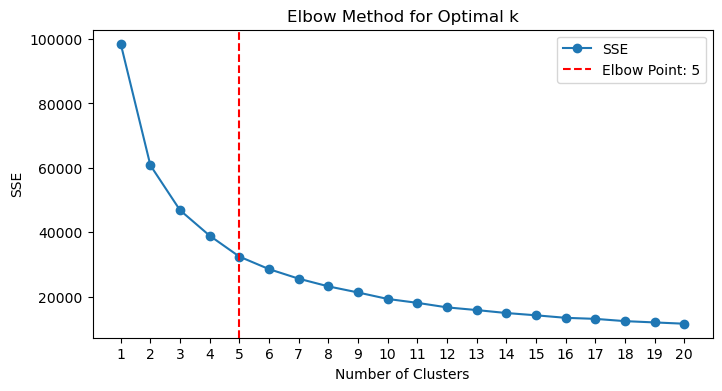

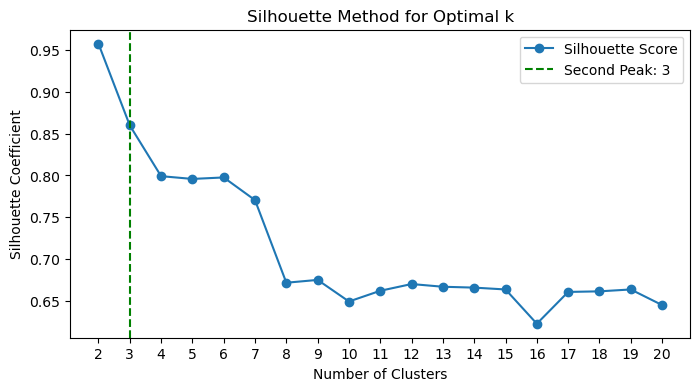

3

In [ ]:
sse_elbow(X, 20)
sil_k_choice(X, 20)

In [ ]:
for k in range(3, 7):
  print("k = ", k)
  kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
  kmeans.fit(X)
  print('labels', np.unique(kmeans.labels_, return_counts=True))
  print('sse', kmeans.inertia_)
  print('silhouette', silhouette_score(X, kmeans.labels_))

k =  3
labels (array([0, 1, 2]), array([15827,   561,    35], dtype=int64))
sse 46856.87949237095
silhouette 0.8609712999015667
k =  4
labels (array([0, 1, 2, 3]), array([ 1024,   103,    21, 15275], dtype=int64))
sse 38912.024951842955
silhouette 0.7976410115212387
k =  5
labels (array([0, 1, 2, 3, 4]), array([  964,    73,    18,    66, 15302], dtype=int64))
sse 32388.94554525334
silhouette 0.793009105901719
k =  6
labels (array([0, 1, 2, 3, 4, 5]), array([15296,    71,   118,    13,    13,   912], dtype=int64))
sse 28706.728787915406
silhouette 0.7949149349635657


In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=4, n_init=10)

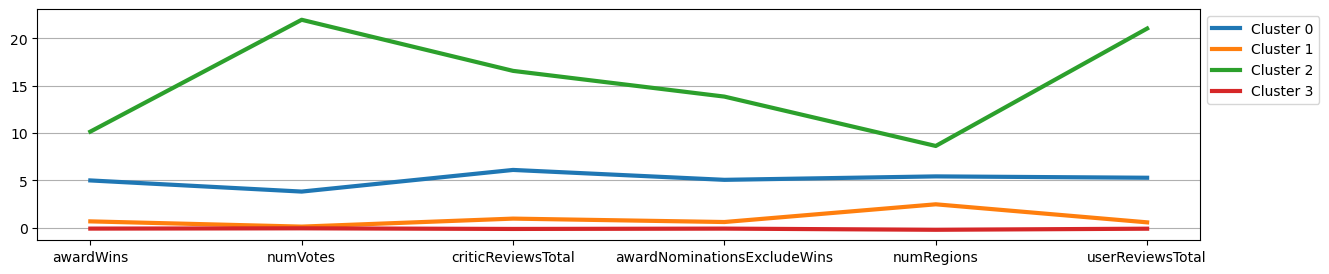

In [ ]:
plt.figure(figsize=(15, 3))

for i in range(len(kmeans.cluster_centers_)):
    n_centroids = len(kmeans.cluster_centers_[i])
    plt.plot(range(0, n_centroids), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=3)
plt.xticks(range(0, n_centroids), list(X.columns))
plt.legend(bbox_to_anchor=(1,1))
plt.grid(axis='y')
plt.tick_params(axis='x')
plt.show()

### Bisecting K-means

In [ ]:
from sklearn.cluster import BisectingKMeans

In [ ]:
bkmeans = BisectingKMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94)
bkmeans.fit(X_scal)

BisectingKMeans(max_iter=100, n_clusters=3, n_init=10, random_state=94)

In [ ]:
centers = scaler.inverse_transform(bkmeans.cluster_centers_)
centers

array([[1.80000000e+01, 2.16224471e+05, 1.61250000e+02, 3.31029412e+01,
        4.46911765e+01, 5.79720588e+02],
       [2.76312719e+00, 7.01313769e+03, 2.42742124e+01, 3.84947491e+00,
        2.04154026e+01, 5.07456243e+01],
       [1.88153310e-01, 2.03210866e+02, 8.72628726e-01, 2.13382372e-01,
        2.43031359e+00, 1.92263518e+00]])

In [ ]:
print('SSE', bkmeans.inertia_)
print('Silhouette', silhouette_score(X_scal, bkmeans.labels_))

SSE 48455.85035039967
Silhouette 0.8236410088580425


# BDSCAN

In [ ]:
X = F.copy(deep = True)

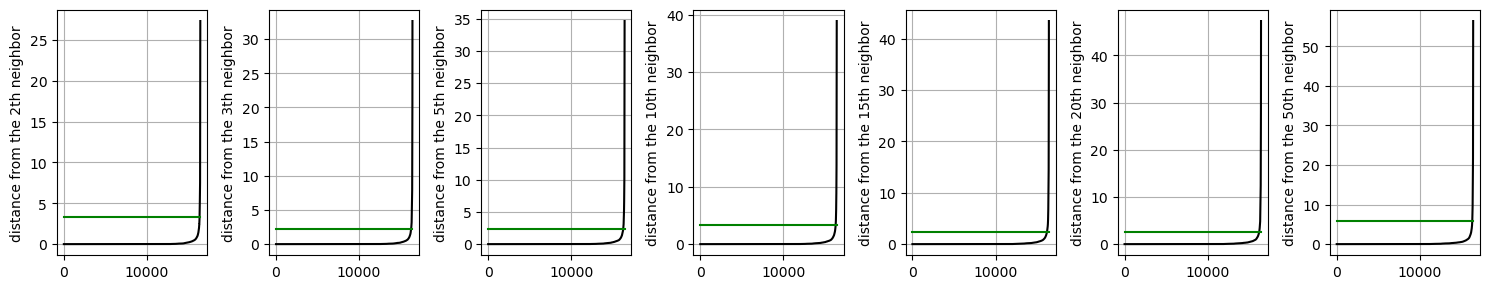

In [ ]:
ks = [2, 3, 5, 10, 15, 20, 50]
X_eps = []


def eps_choice(df, ks, eps_list):
    dist = squareform(pdist(df, 'euclidean'))

    fig = plt.figure(figsize=(15, 3)) # dimensions of the overall plot
    fig_dims = (1, len(ks))

    for i in range(len(ks)):
        k = ks[i]
        kth_distances = []

        for d in dist:  # d is a vector containing distances between the ith record and all the others
            index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
            kth_distances.append(d[index_kth_distance])  # store the distance in a list

        # Sort the distances
        kth_distances.sort()

        # Create an array of indices
        indices = np.arange(len(kth_distances))

        # Use the KneeLocator to find the elbow point
        knee_locator = KneeLocator(indices, kth_distances, curve='convex', direction='increasing')
        elbow_point = knee_locator.knee
        eps_list.append(round(kth_distances[elbow_point], 2))  # Round to 2 decimal places

        plt.subplot2grid(fig_dims, (0, i))
        plt.plot(indices, kth_distances, 'black')
        plt.plot([0, len(kth_distances)], [kth_distances[elbow_point], kth_distances[elbow_point]], 'g-')  # Plot the elbow point
        plt.ylabel('distance from the {}th neighbor'.format(k))
        plt.grid(True)  # This line adds a grid to the plot

    plt.tight_layout()
    plt.show()

eps_choice(X, ks, X_eps)

In [ ]:
print(ks)
print(X_eps)

[2, 3, 5, 10, 15, 20, 50]
[3.33, 2.2, 2.34, 3.36, 2.36, 2.67, 5.73]


In [ ]:
dist = pdist(X_scal, 'euclidean')
dist = squareform(dist)

In [ ]:
def dbscan_results(df, eps, ks):
  for i in range(len(eps)):
    db = DBSCAN(eps=eps[i], min_samples=ks[i]).fit(df)
    labels, counts = np.unique(db.labels_, return_counts=True)
    print(labels, counts)
    print(f"eps={eps[i]}, minPts={ks[i]} -> {len(labels)-1} clusters")
    for i in range(len(labels)):
      print(f"Cluster [{labels[i]}]: {counts[i]} samples")

    clustering_labels = db.fit_predict(df)
    df.loc[:, 'db_labels'] = clustering_labels
    if len(np.unique(db.labels_)) > 2:
        print('Silhouette (F)', silhouette_score(df[db.labels_ != -1], db.labels_[db.labels_ != -1]))
    else:
        print('Cannot calculate silhouette score with only one cluster')

    print("--------------------------------")

dbscan_results(df=X, eps=X_eps, ks=ks)

[-1  0  1  2  3  4  5  6  7  8] [   69 16336     2     3     2     2     2     2     2     3]
eps=3.33, minPts=2 -> 9 clusters
Cluster [-1]: 69 samples
Cluster [0]: 16336 samples
Cluster [1]: 2 samples
Cluster [2]: 3 samples
Cluster [3]: 2 samples
Cluster [4]: 2 samples
Cluster [5]: 2 samples
Cluster [6]: 2 samples
Cluster [7]: 2 samples
Cluster [8]: 3 samples
Silhouette (F) 0.89738840540295
--------------------------------
[-1  0  1  2] [  124 16293     3     3]
eps=2.2, minPts=3 -> 3 clusters
Cluster [-1]: 124 samples
Cluster [0]: 16293 samples
Cluster [1]: 3 samples
Cluster [2]: 3 samples
Silhouette (F) 0.9022610063892958
--------------------------------
[-1  0  1] [  131 16285     7]
eps=2.34, minPts=5 -> 2 clusters
Cluster [-1]: 131 samples
Cluster [0]: 16285 samples
Cluster [1]: 7 samples
Silhouette (F) 0.9079535848283593
--------------------------------
[-1  0] [   98 16325]
eps=3.36, minPts=10 -> 1 clusters
Cluster [-1]: 98 samples
Cluster [0]: 16325 samples
Cannot calculate si

# OPTICS

In [ ]:
X = F.copy(deep = True)

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

optics = OPTICS(min_samples = 50, max_eps = np.inf, min_cluster_size=50)
optics.fit(X)

if len(np.unique(optics.labels_ )) > 2:
  print("Silhouette F", silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1]))
else:
  print('Cannot calculate silhouette score with only one cluster')


c:\Users\hiend\miniconda3\envs\corso\lib\site-packages\sklearn\cluster\_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette F 0.8490870414357966


Text(0.5, 1.0, 'Reachability Plot')

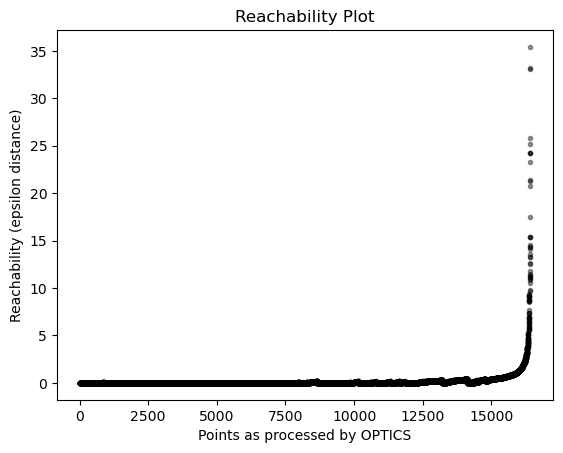

In [ ]:
# Valleys in the plot correspond to the clusters
space = np.arange(len(X))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

# Reachability plot
plt.plot(space, reachability, "k.", alpha=0.4)
plt.xlabel("Points as processed by OPTICS")
plt.ylabel("Reachability (epsilon distance)")
# plt.axhline(0.3, c="red")
plt.title("Reachability Plot")